<h1>Local setup with Anaconda</h1>
<p>You will need the following packages:<p>
<ol>
    <li><a href="https://networkx.github.io/"><b>networkx:</b></a><code> conda install networkx</code></li><br>
    <li><a href="https://github.com/ericmjl/hiveplot"><b>hiveplot:</b></a><code> conda install -c conda-forge hiveplot</code></li><br>
    <li><a href="https://github.com/ericmjl/nxviz"><b>nxviz:</b></a><code> conda install -c conda-forge nxviz</code></li><br>
    <li><a href="https://github.com/taynaud/python-louvain"><b>python-louvain:</b></a><code> conda install python-louvain</code></li><br>
    <li><a href="https://jiffyclub.github.io/palettable/"><b>palettable:</b></a><code> conda install palettable</code></li>
<ol>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm

import networkx as nx
from nxviz import MatrixPlot, ArcPlot, CircosPlot
from hiveplot import HivePlot
import community 
import palettable as pal

%matplotlib inline

<h1>Loading datasets</h1>
<p>There are different file formats for storing network data; in most cases these data are divided into two files: one contains the edges and their attributes, the other contains the nodes and their attributes.<br>
When loading a dataset, you have to decide which class of graphs to use based on the network structure you want to represent.
</p>
<p>
NetworkX provides the following classes:
<ul>
<li> Graph: undirected graphs with self loops </li>
<li> DiGraph: directed graphs with self loops </li>
<li> MultiGraph: undirected graphs with self loops and parallel edges </li>
<li> MultiDiGraph: directed graphs with self loops and parallel edges </li>
</ul>
</p>

In [2]:
def load_windsurfer(communities=False):
    df = pd.read_csv('data/beach/out.moreno_beach_beach', skiprows=2, header=None, sep=' ')
    df.columns = ['surf1', 'surf2','weight']
    G = nx.from_pandas_edgelist(df, source='surf1', target='surf2',edge_attr='weight')
    
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')
            
    return G

def load_trainingbomb(communities=False):
    df = pd.read_csv('data/bombing/out.moreno_train_train', skiprows=2, header=None, sep=' ')
    df.columns = ['terrorist1', 'terrorist2','weight']
    G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
    
    max_w = max(nx.get_edge_attributes(G, 'weight').values())
    normalized_w = {(v1,v2): 1 + (w['weight']/max_w) * 5 for v1,v2,w in G.edges(data=True)}
    nx.set_edge_attributes(G,normalized_w,'normalized_weight')
    
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')

    return G

def load_facebook(communities=False):
    df = pd.read_csv('data/facebook/out.ego-facebook', skiprows=2, header=None, sep=' ')
    df.columns = ['user1', 'user2']
    G = nx.from_pandas_edgelist(df, source='user1', target='user2')
    
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')
    
    return G

<a href="http://konect.uni-koblenz.de/networks/moreno_train"><h3>Train bombing dataset</h3></a>
<p>This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11 2004, as reconstructed from newspapers. A node represents a suspect and an edge between two nodes shows that there was a contact between the two individuals. The weight of the edge denotes how 'strong' a connection was. Connections include friendship and co-participating in training camps or previous attacks.</p>

In [3]:
G = load_trainingbomb(communities=True)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<h1>Graph visualization</h1>

<p>The most important thing regarding the traditional visualization of a graph is to assign the coordinates to each node. <br>
To obtain more pleasant visualizations, libraries such as <code>NetworkX</code> provide methods to draw a graph with different layouts.
Some layout types are independent of connectivity patterns (random, circular, spiral, shell).<br>
Other layouts, on the other hand, are based on physical models in which each node is assigned an electric charge that applies a repulsive force towards the other nodes; the edges instead simulate an elastic force that attracts adjacent nodes.
The model iteratively determines the resulting forces acting on the nodes and attempts to bring them to a state of balance in which all forces add up to zero and their position remains stable. These layouts are called <b>force-directed layouts</b> (Kamada-Kawai, spring, spectral).</p>
<p>If the network is large, visualizations begin to look like <b>hairballs</b> and you can not get any useful information about its features. <br> A solution to this problem is to visualize networks following a <b>rational visualization approach</b>, such as arc plots, circos plots and hiveplots. <br> The principle behind <b>rational visualization</b> is to prioritize the placement of nodes in a certain way and then look at the edges and how they are structured according to the organization of the nodes.</p>

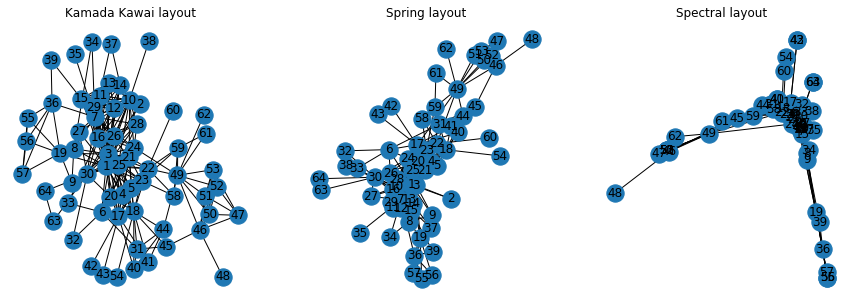

In [4]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Kamada Kawai layout")
nx.draw_kamada_kawai(G, with_labels=True)

plt.subplot(1,3,2)
nx.draw_spring(G, with_labels=True)
plt.title("Spring layout")

plt.subplot(1,3,3)
nx.draw_spectral(G, with_labels=True)
plt.title("Spectral layout")

plt.show()

<h3>Arc plot</h3>
<p>In arc diagrams, nodes are displayed along a single axis and links are represented with arcs.<br>Nodes can be grouped or ordered by a criteria in order to visualize the <b>density</b> of the connections between groups.</p>

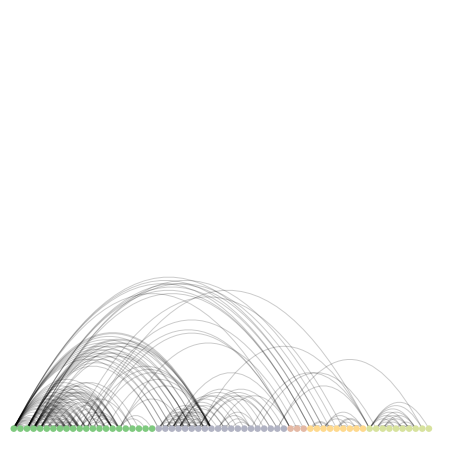

In [5]:
a = ArcPlot(G, node_color='group', node_grouping='group', figsize=(8,8), edge_width='weight')
a.draw()

<h3>Circos plot</h3>
<p>This visualization helps us highlight nodes that there are <b>poorly connected</b>, and the ones that are <b>strongly connected</b>.</p>

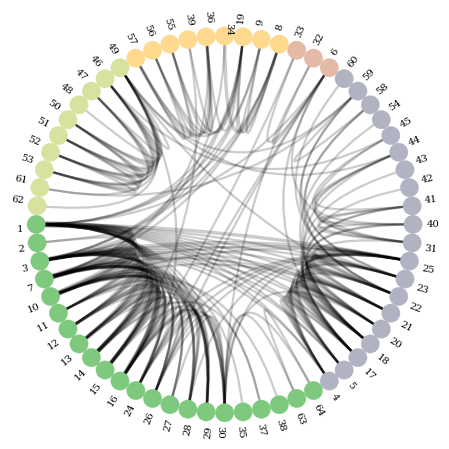

In [6]:
c = CircosPlot(G, node_color='group', node_grouping='group', node_labels=True, figsize=(8,8),
               node_label_layout='rotation', fontsize=10, edge_width="normalized_weight")
c.draw()

<h3>Hiveplots</h3>
<p>Hive plots allow us to divide our nodes into sub-groups and visualize the within- and between-group connectivity.</p>

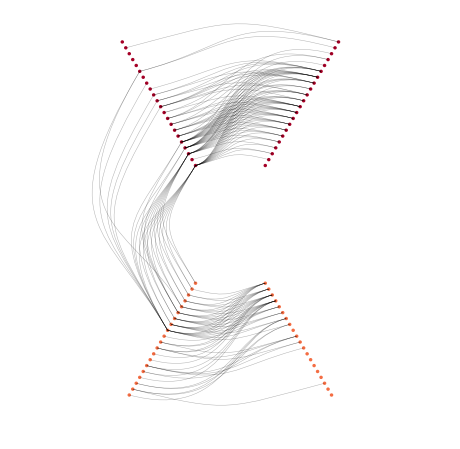

In [7]:
colors=['#a50026','#f46d43','#fee090','#abd9e9','#313695','#762a83','#1b7837','#dfc27d']
groups=list(pd.Series(community.best_partition(G)).value_counts()[:2].index)
nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges_cmap = {'group1':'black'}
edges = dict()
edges['group1'] = G.subgraph([n for n in G.nodes() if (G.nodes()[n]['group'] in groups)]).edges(data=True)

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<h3>Adjacency matrix</h3>
<p>
Another way to analyze graphs is to use an <b>adjacency matrix</b>. However, if we compute an adjacency matrix of a large graph, the result will usually be a sparse matrix that shows no connectivity patterns. To solve this problem algorithms that permute rows and columns (bandwidth reduction permutations) are used, combined with optimization procedures (minimum degree ordering, reverse Cuthill-McKee ordering) and the highlighting of connectivity patterns (for example tightly connected groups of nodes).</p>

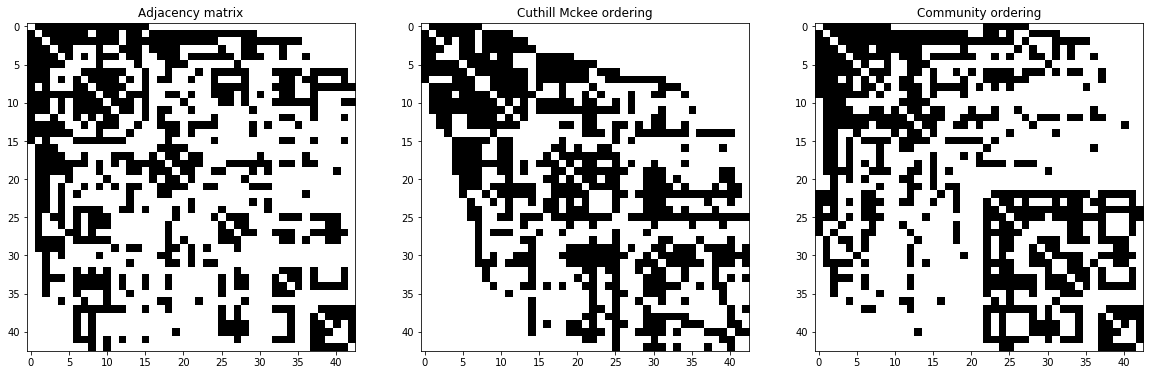

In [8]:
from networkx.utils import cuthill_mckee_ordering
from collections import defaultdict

def draw_adjacency_matrix(G, node_order=None, partitions=[]):
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    plt.imshow(adjacency_matrix, cmap="Greys")

G = load_windsurfer()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
draw_adjacency_matrix(G)
plt.title("Adjacency matrix")

plt.subplot(1, 3, 2)
rcm = list(cuthill_mckee_ordering(G))
draw_adjacency_matrix(G, node_order=rcm)
plt.title("Cuthill Mckee ordering")

plt.subplot(1, 3, 3)

communities = defaultdict(list)
for n_index, comm_id in community.best_partition(G).items():
    communities[comm_id].append(n_index)
communities = communities.values()

nodes_comm_ordered = [node for comm in communities for node in comm]

draw_adjacency_matrix(G, nodes_comm_ordered, [communities])
plt.title("Community ordering")

plt.show()

<h1>Centrality measures</h1>
<p>
    <a href="https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html">Centrality measures</a> identify the most important vertices of a graph.<br>
    Note that the word "important" can have different interpretations, thus there are different measures of centrality.<br>
    <ul>
        <li><b>Degree centrality:</b> the number of nearest neighbours (local measurement). 
In practice, a node with a high Degree centrality indicates that it has direct contact with many other nodes.</li>
        <li><b>Closeness centrality:</b> the average length of the shortest path between the node and all other nodes in the graph. It indicates how close a node is to all other nodes in the network. 
In practice, a node with a high Closeness centrality indicates that to communicate with the other nodes it needs on average fewer steps than those with a low Closeness centrality (it has a short communication path with others).</li>
        <li><b>Eigenvector centrality: </b> we can give a recursive definition: the importance of a node depends on the importance of its neighbours. Nodes with high eigenvector centrality are usually grouped in the same cluster.
</li>
        <li><b>Betweenness centrality: </b> the number of shortest paths going through the node. In practice, a node with high Betweenness centrality acts as a bridge along the shortest path between two other nodes (useful to identify information flow or the spread of a virus).</li>
    </ul>
</p>  
<p>
    There are also centrality measures related to the whole graph called <b>Centralizations</b>. They indicate how central is the node which has the highest value of a certain measure of centrality in relation to the other nodes. These measures are used to compare the centrality between graphs.</p>
<p>When talking about direct graphs, the measurements seen above refer to the outgoing edges and are slightly different to take into account the direction of the edges.<br>
   Looking at the incoming edges we can define the measure of <b>prestige</b> of a node which is similar to the Eigenvector centrality: the prestige of a node depends on the prestige of the nodes that point it. This measure cannot always be calculated (due to cycles, source nodes ...). <br>    
Over time, new ranking measures of nodes have been introduced, especially in the context of web search.</p>

<p>
<b><a href="https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html">PageRank</a></b> assigns a score of importance to each node. Important nodes are those with many in-links from other important nodes. <br>
Steps of a basic PageRank:
    <ol>
        <li>All nodes starts with a PageRank of 1/n</li>
        <li>Perform the basic PageRank Update Rule K times:
            <ul>
                <li>Each node gives an equal share of its current PageRank to all the nodes it links to</li>
                <li>The new PageRank of each node is the sum of all the Pagerank it received from other nodes</li>
            </ul>
    </ol>
For most networks, PageRank converges as K gets larger.<br>
The page rank is similar to the node's in-degree, but it also depends on the page rank of the in-degree nodes. For that reson, in direct networks, nodes with a high in-degree do not always have a high page rank.
The PageRank of a node at step K can be interpreted as the probability that a random walker lands on the node after taking K steps. To avoid cycles, a "dumping parameter" &alpha; is also introduced, so that the random walker chooses a random node to jump with probability 1 - &alpha;.
</p>
<p>
    The <b><a href="https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.link_analysis.hits_alg.hits.html">Hyperlink-Induced Topic Search (HITS) algorithm</a></b> introduces two other metrics for a node that allows you to differentiate the role of each node within the graph: <b>hubs</b> and <b>authorities</b> (information aggregator vs information creator). As part of a network of citations, for example, an authority score and a hub score can be assigned to a paper. A paper with a high authority score is a paper that is cited in good review papers. A paper with a high hub score is a node that cites good papers (Good authorities referred by good hubs and good hubs point to good authorities).<br>
Steps of a HITS algorithm:
        <ol>
        <li>Assign each node an authority and hub score of 1</li>
        <li>Apply the Authority Update Rule: each node's authority score is the sum of hub scores of each node that POINTS TO IT.
        <li>Apply the Hub Update Rule: each node's hub score is the sum of authority scores of each node that IT POINTS TO </li>
        <li> Normalize Authority and Hub scores
    </ol>
    Authority and hub scores converge for most networks.
</p>

<h3>Centrality measures in Trainboming dataset</h3>
<p>We can use a Circos plot to understand which terrorists have the most direct contact with other terrorists. For an easier understanding, the nodes can be coloured based on the Degree centrality value.</p>

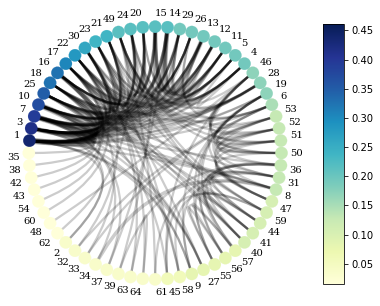

In [9]:
G = load_trainingbomb(communities=True)

centr = {k: v for k, v in  nx.degree_centrality(G).items()}
for n in centr:
    G.nodes[n]['centrality'] =  centr[n]
c = CircosPlot(G, node_color='centrality', node_grouping='centrality', node_labels=True, edge_width="normalized_weight")
c.draw()

<p>Since the graph is not too large, we can visualize it in the standard way and show how the various centrality measures perform.</p>

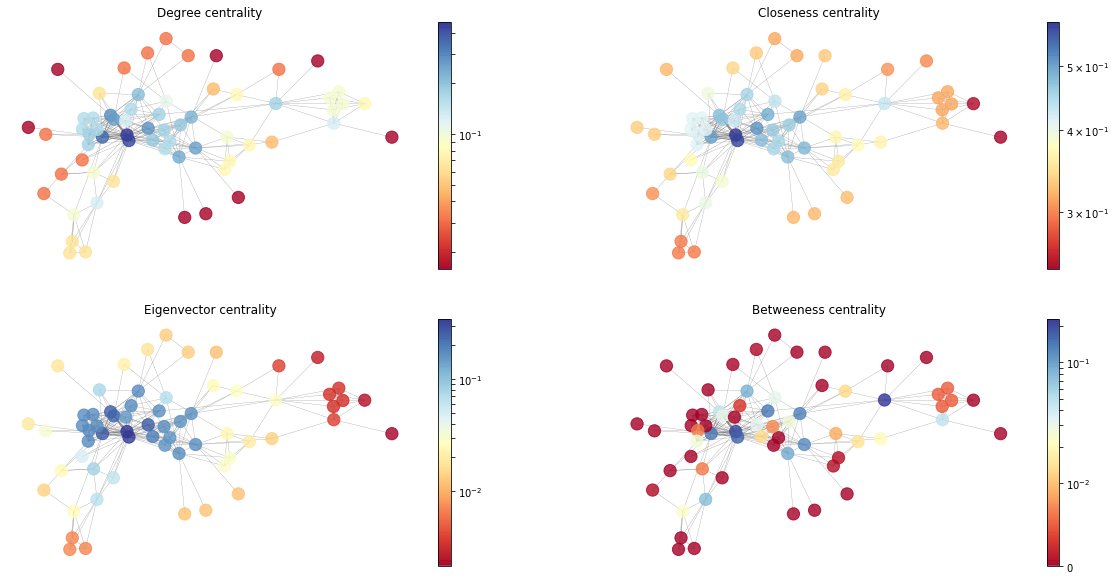

In [10]:
#We define here a function that allows to draw a graph by colouring the nodes according to the value of a measurement.
def draw_measure(G, pos, title, node_size, cmap, measure, show=False, scale_color=True, color_bar=True):

    if measure: 
        nodes =  nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=cmap, alpha=.8,
                                   node_color=list(map(float,measure.values())),
                                   nodelist=list(map(float,measure.keys())))
    else:
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size)
                
    if scale_color:
        nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    edge_width = [0.25 * G[u][v]['weight'] for u,v in G.edges()]
    edges = nx.draw_networkx_edges(G, pos, edge_color= "gray", width=edge_width)

    plt.title(title)
    
    if color_bar:
        plt.colorbar(nodes)
        
    plt.axis('off')
    
    if show:
        plt.show()

pos = nx.spring_layout(G)
cmap = pal.colorbrewer.diverging.RdYlBu_11.mpl_colormap
node_size=150


plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
draw_measure(G, pos, 'Degree centrality', node_size, cmap, nx.degree_centrality(G))

plt.subplot(2, 2, 2)
draw_measure(G, pos, 'Closeness centrality', node_size, cmap, nx.closeness_centrality(G))

plt.subplot(2, 2, 3)
draw_measure(G, pos, 'Eigenvector centrality', node_size, cmap, nx.eigenvector_centrality(G))

plt.subplot(2, 2, 4)
draw_measure(G, pos, 'Betweeness centrality', node_size, cmap, nx.betweenness_centrality(G), show=True)

<h3>HITS Algorithm example</h3>

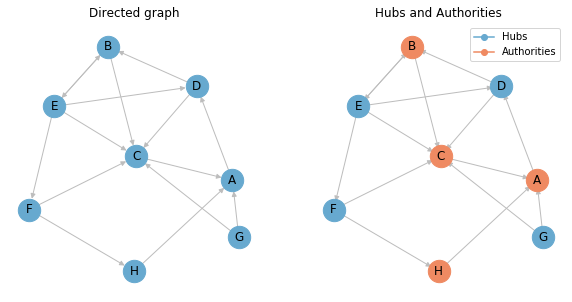

In [11]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10, 5))

Ghits = nx.DiGraph()
Ghits.add_edges_from([('A','D'), ('B','E'),('B','C'),('C','A'),('D','B'), ('D','C'),
                         ('E','B'),('E','C'),('E','D'),('E','F'),('F','C'),('F','H'),('G','A'),('G','C'),('H','A')])

pos = nx.kamada_kawai_layout(Ghits)

plt.subplot(1, 2, 1)
nx.draw_networkx(Ghits, pos=pos, with_labels=True,node_size=500, edge_color="#bdbdbd", node_color='#67a9cf')

plt.axis('off')
plt.title('Directed graph')

plt.subplot(1, 2, 2)

hubs, authorities = nx.hits(Ghits)
selectedHubs = {k:v for k,v in hubs.items() if v >= authorities[k]}
selectedAuthorities = {k:v for k,v in authorities.items() if v > hubs[k]}

nodes = nx.draw_networkx_nodes(selectedHubs, pos, node_size=500, node_color='#67a9cf')
hub_labels = {k:k for k in selectedHubs.keys()}
nx.draw_networkx_labels(selectedHubs,pos, labels=hub_labels)

nodes = nx.draw_networkx_nodes(selectedAuthorities, pos, node_size=500, node_color='#ef8a62')
auth_labels = {k:k for k in selectedAuthorities.keys()}
nx.draw_networkx_labels(selectedHubs,pos,labels=auth_labels)

nx.draw_networkx_edges(Ghits, pos, edge_color= "#bdbdbd", arrows=True )

plt.axis('off')
plt.title('Hubs and Authorities')

line1 = Line2D(range(1), range(1), color="#67a9cf", marker='o')
line2 = Line2D(range(1), range(1), color="#ef8a62", marker='o')
plt.legend((line1,line2),('Hubs','Authorities'), numpoints=1, loc=1)

plt.show()

<h1>Community detection algorithms</h1>
<p>

A <b><a href="https://networkx.github.io/documentation/stable/reference/algorithms/clique.html">clique</a></b> is a complete (fully connected) subgraph, i.e. a set of vertices where each pair of vertices is connected (Cliques can overlap).<br>
A <b>maximal clique</b> is a clique that cannot be extended by including one more adjacent vertex (not included in larger one).
A <b>maximum clique</b> is a clique of the largest possible size in a given graph.
</p>
<p>
<b>Network communities</b> (cohesive subgroups) are groups of vertices that have dense connections internally and sparser connections between groups (the vertices inside a community have many more connections between them than with the ones outside the community).
A clique is a sort of ultimate community (maximum possible density) so the definition of a network community is a relaxation of the definition of a clique.<br>
<b>Community detection</b> is an assignment of vertices to communities (we will consider non-overlapping communities: a node can belong to only one community).
</p>

<p>
We can use the <a href="https://networkx.github.io/documentation/stable/reference/generated/networkx.classes.function.density.html#networkx.classes.function.density"><b>density</b></a> measurement of a graph to see if the community found is correct.
<ol>
    <li> We measure the density of the whole graph (ρ) </li>
    <li> We measure the density of the edges outside the community (δext)</li>
    <li> Density is measured within the community (δint)</li>
</ol>    
If δint>ρ and δext<ρ then the community is correct.
</p>

<p>
The problem of identifying communities can be translated into the problem of finding the <b>optimal graph cuts</b>.<br>
By <a href="https://networkx.github.io/documentation/stable/reference/algorithms/cuts.html"><b>graph cut</b></a> we mean removing some edges in order to separate the graph into pieces. <br>
Measures can be defined to understand how many edges must be cut from the graph to identify the communities and evaluating the graph cuts (ratio cut, normalized cut, conductance).
</p>

<p>
<b><a href="https://en.wikipedia.org/wiki/Modularity_(networks)">Modularity</a></b> is one measure of the structure of networks or graphs. It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks. It compares the fraction of edges within a cluster to expected random graph with identical degree sequence.
When you split a graph into communities, modularity tells you how much denser a part that is a community is compared to a random graph. 
</p>

<p>
<b><a href="https://networkx.github.io/documentation/stable/reference/algorithms/community.html">Community detection algorithms</a></b> can be both greedy or heuristics algorithms. In general, there are two approaches to finding communities: multiway partitioning (trying to cut out community areas by looking at the graph you) and recursive partitioning.<br>
Some community detection algorithms are basically optimization algorithms of some measure (density, cut graph, modularity).
</p>

<p>Listed below are some community detection algorithms.<br>
<b>Edge betweenness algorithm (Newman-Girven, 2004):</b> greedy algorithm with a focus on edges that connect communities<br>
<b>Spectral modularity partition (Newman, 2004) - Leading eigenvector:</b> algorithm with a focus on modularity maximization<br>
<b>Label propagation algorithm (U.N. Raghavan, R. Albert, S. Kamura, 2007):</b> it's a heuristic algorithm<br>
<b>Fast community unfolding algorithm:</b> a heuristic method for greedy modularity optimization that follows the Louvain method. This method is not based on the graph cut but starts with the nodes assigned to a certain cluster and
change the cluster of a node only if it increases modularity. This algorithm is currently one of the most used because it's very efficient and scalable. <br>
<b>Walktrap community:</b> it is about combining nodes together and not about cutting the graph and it is based on the concept on the random walk. The idea is that if a path starts from a node within a community, the path will remain there for a long time before going out
<p>
  
<h3><a href="https://arxiv.org/pdf/0803.0476.pdf">Louvain’s Algorithm for Community Detection</a></h3>
<p>Louvain’s algorithm is based on optimising the Modularity. Modularity captures the concept that the density of edges inside communities is greater than the density of edges outside communities and is used to quantify the quality of identified communities. <img src="images/Modularity.png" height="1000px" width="500px"/></p>
<p>The algorithm iteratively performs two phases: <b>Modularity optimization</b> and <b>Community aggregation</b>. Both will be executed until there are no more changes in the network and maximum modularity is achieved.</p>

<b>Steps followed in the Modularity optimization phase:</b>
<ol>
   <li>To start each node is assigned to a different community (N nodes = N communities).</li>
     <li>For each neighbour j of node i, it is checked if the overall modularity increases by moving i from its partition to partition j. The node i is moved to partition j for which the gain of modularity is highest.</li>
    <li>Step 2 is repeated for all the nodes in a sequential manner. This is called one iteration. The iteration is also repeated until no improvement in modularity can be achieved (till a local maximum of modularity is reached).</li>
</ol>
<b>Community aggregation phase:</b><br>
The Community aggregation phase involves rebuilding a new network by grouping together the nodes labelled in the same community (the nodes belonging to the same community are merged into a single giant node).
The weights of the edges between two of the newly created communities are determined by adding up the weights of edges that connect one community to the other. This phase also generates self-loops which are the sum of all links inside a given community (before it was collapsed into a single node).
<br><br>
One iteration of Modularity optimization and Community aggregation is called a pass. After every pass, the number of communities reduces. This goes on until there is no change in community labels and maximum modularity is reached.
<img src="images/Louvain.png" />

<h1>Example of large graph visualization: <a href="http://konect.uni-koblenz.de/networks/facebook-wosn-links">Facebook dataset</a></h1>
<p>This undirected network contains data about the friendship between Facebook users. A node represents a user and an edge represents a link of friendship between two users. Note that this dataset is obviously not complete and contains a very small subset of the total Facebook friendship graph.</p>

In [12]:
G = load_facebook(communities=True)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2888
Number of edges: 2981
Average degree:   2.0644


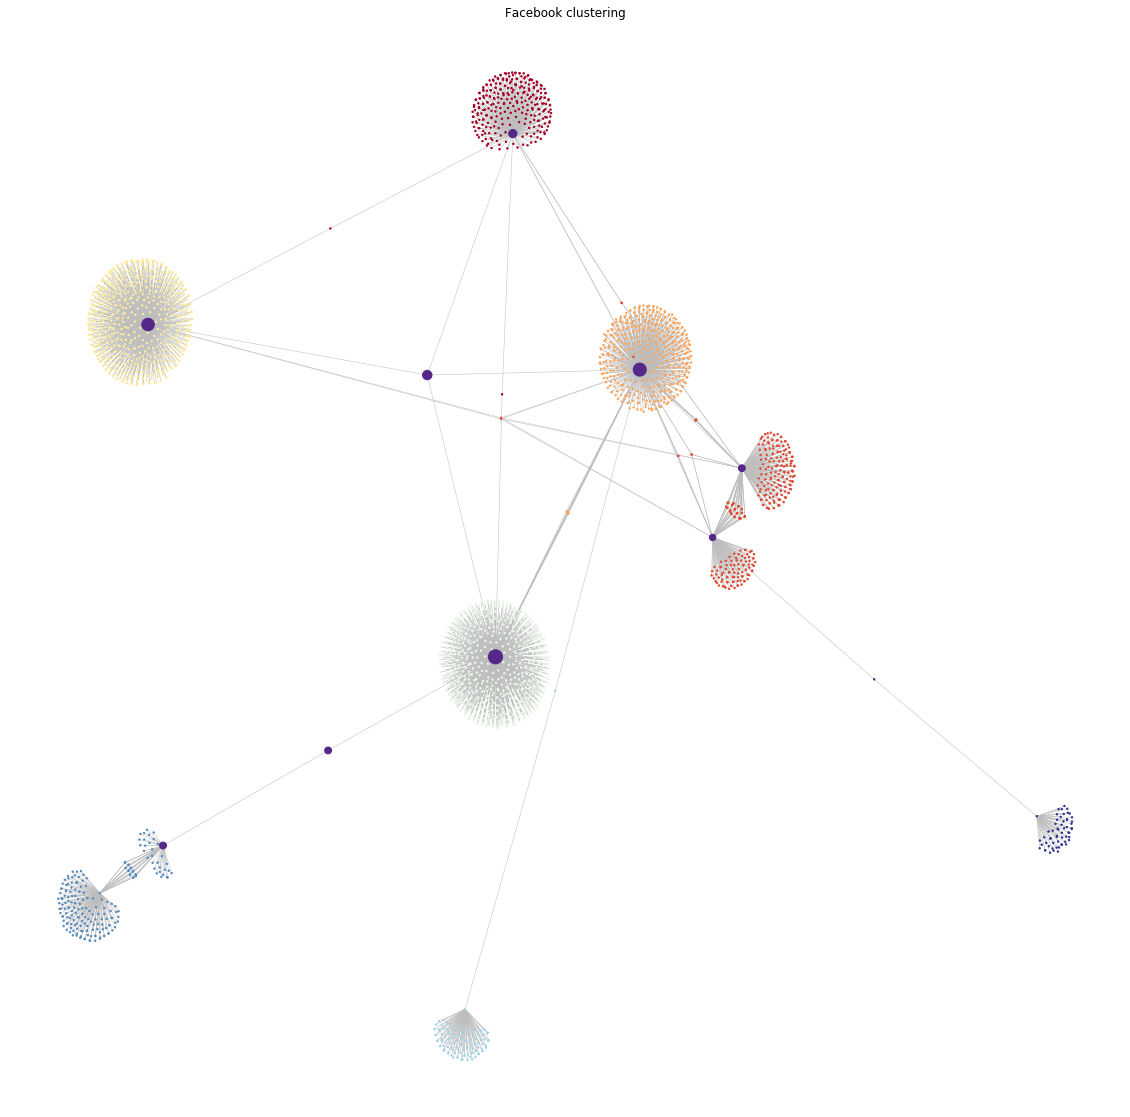

In [13]:
plt.figure(figsize=(20, 20))

pos = nx.spring_layout(G, seed=1)

cmap = pal.colorbrewer.diverging.RdYlBu_11.mpl_colormap
nodes = nx.draw_networkx_nodes(G, pos, node_size=2, cmap=cmap, 
                                   node_color=list(map(float,dict(G.nodes.data(data='group')).values())),
                                   nodelist=list(map(float,dict(G.nodes.data(data='group')).keys())))

edges = nx.draw_networkx_edges(G, pos, edge_color= "#bdbdbd", width =.5)

high_betweenness = {k: v for k, v in nx.betweenness_centrality(G, normalized=True).items() if v > 0.1}
pos_high_bet = {k: pos[k] for k, _ in high_betweenness.items()}
group_bet = {k: G.nodes(data=True)[k]['group'] for k, _ in high_betweenness.items()}
node_bet_size = [ v*200/max(high_betweenness.values()) for v in high_betweenness.values()]
nodes = nx.draw_networkx_nodes(high_betweenness, pos_high_bet, node_size=node_bet_size,
                                   node_color='#542788')

plt.title('Facebook clustering')
plt.axis('off')
plt.savefig('images/facebook.png', dpi=300)
plt.show()